In [29]:
import os
import pandas as pd

root_folder = "./speech_audio"  # contains Unclear/, Moderate/, Confident/
data = []

for label in ["Unclear", "Moderate", "Confident"]:
    folder_path = os.path.join(root_folder, label)
    for fname in os.listdir(folder_path):
        if fname.endswith(".wav") or fname.endswith(".mp3"):
            data.append([os.path.join(folder_path, fname), label])

df = pd.DataFrame(data, columns=["filename", "label"])
df.to_csv("labeled_audio_dataset.csv", index=False)


In [30]:
import noisereduce as nr
def denoise_audio(y, sr):
    return nr.reduce_noise(y=y, sr=sr)

In [31]:
import librosa
import numpy as np
import noisereduce as nr  #  Added import

def denoise_audio(y, sr):
    return nr.reduce_noise(y=y, sr=sr)

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)

        #  Apply noise reduction
        y = denoise_audio(y, sr)

        # --- MFCC Features (mean of 40 coefficients) ---
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_variance = np.var(mfcc)

        # --- Pitch (F0) Features ---
        f0, _, _ = librosa.pyin(y, fmin=50, fmax=300)
        f0_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0
        pitch_variation = np.nanstd(f0) if np.any(~np.isnan(f0)) else 0

        # --- Energy (RMS) Features ---
        rms = librosa.feature.rms(y=y).flatten()
        rms_mean = np.mean(rms)
        energy_stability = np.std(rms)

        # --- Pause-related Features ---
        pause_threshold = 0.01
        pause_frames = rms <= pause_threshold
        pause_frequency = np.sum(pause_frames)
        pause_duration = np.sum(pause_frames) * (512 / sr)
        speaking_rate = np.sum(rms > pause_threshold)

        # --- Articulation Rate (simplified as RMS mean) ---
        articulation_rate = rms_mean

        return [
            file_path,
            *mfcc_mean,
            f0_mean,
            pitch_variation,
            rms_mean,
            energy_stability,
            pause_frequency,
            pause_duration,
            speaking_rate,
            mfcc_variance,
            articulation_rate
        ]

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [20]:
import pandas as pd
from tqdm import tqdm

# STEP 1: Load your labeled file list
df_labels = pd.read_csv("labeled_audio_dataset.csv")  # already created earlier
all_audio_files = df_labels["filename"].tolist()
all_labels = df_labels["label"].tolist()

# STEP 2: Extract features and collect them
features = []
for file_path, label in tqdm(zip(all_audio_files, all_labels), total=len(all_labels)):
    feats = extract_features(file_path)
    if feats:
        features.append(feats + [label])  # Append label at the end

# STEP 3: Define column names
columns = (
    ["filename"] +
    [f"mfcc_{i}" for i in range(40)] +
    ["f0_mean", "pitch_variation", "rms_mean", "energy_stability",
     "pause_frequency", "pause_duration", "speaking_rate",
     "mfcc_variance", "articulation_rate",
     "label"]  # last column is your class label
)

# STEP 4: Convert to DataFrame
df_features = pd.DataFrame(features, columns=columns)

# STEP 5: Save to CSV
df_features.to_csv("features_with_labels.csv", index=False)
print("Feature extraction complete. Saved to features_with_labels.csv!")

  3%|█▏                                       | 53/1849 [00:05<03:24,  8.79it/s]/Users/aroofapanjwani/Desktop/Spring_2025/Cmpt_419/AI-Based-Public-Speaking-Feedback-System/419venv/lib/python3.10/site-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/Users/aroofapanjwani/Desktop/Spring_2025/Cmpt_419/AI-Based-Public-Speaking-Feedback-System/419venv/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=0
  return f(*args, **kwargs)
100%|███████████████████████████████████████| 1849/1849 [04:54<00:00,  6.27it/s]

Feature extraction complete. Saved to features_with_labels.csv!


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

df = pd.read_csv("features_with_labels.csv")

X = df.drop(columns=["filename", "label"] + [f"mfcc_{i}" for i in range(40)])
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


joblib.dump(scaler, "supervised_scaler.pkl")

['supervised_scaler.pkl']

In [48]:
# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

# Best model
model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

joblib.dump(model, "speech_feedback_model.pkl")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


['speech_feedback_model.pkl']

Classification Report:

              precision    recall  f1-score   support

   Confident       0.99      1.00      1.00       152
    Moderate       0.95      0.87      0.91        92
     Unclear       0.92      0.97      0.94       126

    accuracy                           0.96       370
   macro avg       0.95      0.95      0.95       370
weighted avg       0.96      0.96      0.96       370



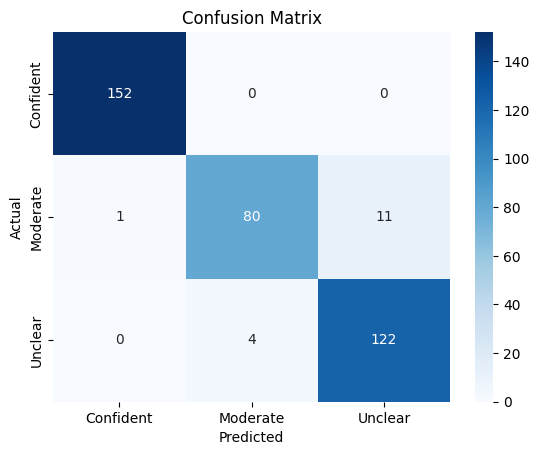

In [50]:
# Evaluate the model
y_pred = model.predict(X_test_scaled)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
labels_order = ["Confident", "Moderate", "Unclear"]
cm = confusion_matrix(y_test, y_pred, labels=labels_order)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [51]:
def generate_feedback(predicted_label):
    feedback_dict = {
        "Confident": "Great job! Your speech is fluent and confident.",
        "Moderate": "Your speech is moderate. Try adding more energy and variation.",
        "Unclear": "Your speech seems unclear. Try reducing pauses and improving clarity."
    }
    return feedback_dict.get(predicted_label, "Unable to generate feedback.")

In [45]:
def predict_and_feedback(file_path):
    features = extract_features(file_path)
    if features is None:
        print("Feature extraction failed.")
        return None, None

    # Extract only the final 9 features used in training
    feature_vector = features[-9:]

    # Load model and scaler
    model = joblib.load("speech_feedback_model.pkl")
    scaler = joblib.load("supervised_scaler.pkl")

    # Prepare input as a DataFrame
    input_df = pd.DataFrame([feature_vector], columns=[
        "f0_mean", "pitch_variation", "rms_mean", "energy_stability",
        "pause_frequency", "pause_duration", "speaking_rate",
        "mfcc_variance", "articulation_rate"
    ])

    # Scale and predict
    input_scaled = scaler.transform(input_df)
    predicted_label = model.predict(input_scaled)[0]

    # Generate feedback
    feedback = generate_feedback(predicted_label)

    print(f"Predicted Category: {predicted_label}")
    print(f"Feedback: {feedback}")
    return predicted_label, feedback


In [62]:
# Example usage
predict_and_feedback("./Test_audio/Bad_Speaking_21.wav")

Predicted Category: Unclear
Feedback: Your speech seems unclear. Try reducing pauses and improving clarity.


('Unclear',
 'Your speech seems unclear. Try reducing pauses and improving clarity.')